<a href="https://colab.research.google.com/github/JoaquinAprendizaje/TC2008B_M1.Actividad/blob/main/M1_Actividad1Clase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instrucciones
### Dado:

- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

### Realiza la siguiente simulación:

- Inicializa las celdas sucias (ubicaciones aleatorias).
- Todos los agentes empiezan en la celda [1,1].
#### En cada paso de tiempo:
- Si la celda está sucia, entonces aspira.
- Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
- Se ejecuta el tiempo máximo establecido.

### Deberás recopilar la siguiente información durante la ejecución:

- Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
- Porcentaje de celdas limpias después del termino de la simulación.
- Número de movimientos realizados por todos los agentes. 

## Imports

Antes de empezar a crear el modelo con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [ ]:
import numpy as np
import pandas as pd
import time
import datetime
import random
!pip install mesa
#!python3 -m pip install numpy
#!pip3 install pandas
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model 

# Debido a que necesitamos un solo agente por celda elegimos `SingleGrid` que fuerza un solo objeto por celda.
from mesa.space import SingleGrid, MultiGrid

# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128



In [ ]:
def get_grid(model):
    '''
    Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
    param model: El modelo del cual optener el grid.
    return una matriz con la información del grid del agente.
    '''
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        for obj in cell_content:
            if isinstance(obj, RobotLimpieza):
                grid[x][y] = 2
            elif isinstance(obj, Celda):
                grid[x][y] = obj.estado
    return grid

class RobotLimpieza(Agent):
    '''
    Descripcion
    '''
    def __init__(self, unique_id, model: Model):
        super().__init__(unique_id, model)
        self.sig_pos = None

    def step(self):
        vecinos = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=True)
        # Maquina de estados
        for vecino in vecinos:
            if isinstance(vecino, Celda) and self.pos == vecino.pos:
                if vecino.estado == 1:
                    #Limpiar
                    vecino.sig_estado = 0
                    self.sig_pos = self.pos
                else:
                    vecinos_2 = self.model.grid.get_neighborhood(
                        self.pos,
                        moore=True,
                        include_center=False)
                    vecino.sig_estado = 0
                    self.sig_pos = self.random.choice(vecinos_2)
                break
        #

    def advance(self):
        vecinos = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=True)
        for vecino in vecinos:
            if isinstance(vecino, Celda) and self.pos == vecino.pos:
                vecino.estado = vecino.sig_estado
                break
        self.model.grid.move_agent(self, self.sig_pos)


In [ ]:
class Celda(Agent):
    '''
    Descripcion

    # 1 Sucio
    # 0 Limpio
    '''
    def __init__(self, unique_id, model, estado):
        super().__init__(unique_id, model)
        self.pos = unique_id
        self.estado = estado
        self.sig_estado = None

In [ ]:
class Habitacion(Model):
    def __init__(self, M, N, num_agentes, porc_celdas_sucias):
        self.num_agentes = num_agentes
        self.porc_celdas_sucias = porc_celdas_sucias
        self.por_celdas_limpias = 1 - porc_celdas_sucias
        self.grid = MultiGrid(M, N, False)
        self.schedule = SimultaneousActivation(self)
        contador = 0
        #Colocacion de celdas sucias o limpias
        num_celdas_sucias = int(M*N*porc_celdas_sucias)
        for (content, x, y) in self.grid.coord_iter():
            num = random.randint(0,1)
            if (num == 1 and num_celdas_sucias > 0):
                a = Celda((x, y), self, 1)
                num_celdas_sucias -= 1
            else:
              if M*N - contador == num_celdas_sucias:
                a = Celda((x, y), self, 1)
                num_celdas_sucias -= 1
              else:
                a = Celda((x, y), self, 0)
            contador +=1

            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)

        # Colocacion de limpiadoras
        for id in range(num_agentes):
            r = RobotLimpieza(id, self)
            self.grid.place_agent(r, (1, 1))
            self.schedule.add(r)

        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid})
        
    def step(self):     
        self.datacollector.collect(self)
        self.schedule.step()

    def isNotClean(self):
        for (content, x, y) in self.grid.coord_iter():
            for obj in content:
                if isinstance(obj, Celda) and obj.estado == 1:
                  return True
        return False

In [ ]:
M = 10
N = 10
num_agentes = 5
porc_celdas_sucias = .5
tiempo_maximo = .15

model = Habitacion(M, N, num_agentes, porc_celdas_sucias)
start_time = time.time()

while ((time.time() - start_time) < tiempo_maximo and model.isNotClean()):
    model.step()


print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:00:00.044139


In [ ]:
all_grid = model.datacollector.get_model_vars_dataframe()
all_grid

,Grid
0,"[[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0,..."
1,"[[1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0,..."
2,"[[2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0,..."
3,"[[2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0,..."
4,"[[0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0,..."
...,...
136,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
137,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
138,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
139,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))


In [ ]:
anim

  ### Diagrama de Maquina de Estados
  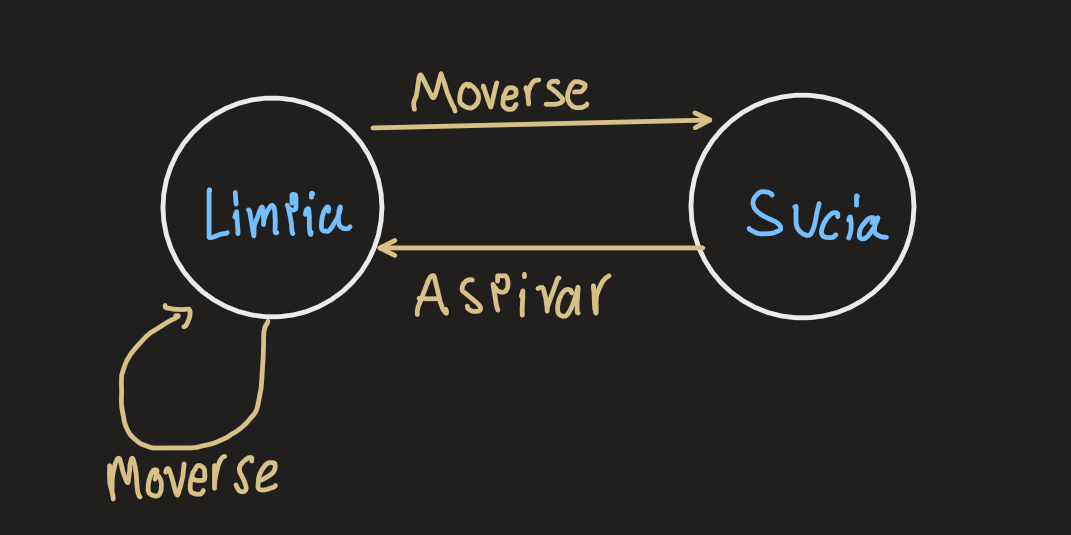

### Análisis del impacto de agentes al tiempo de limpieza.
A través de la ejecución del programa y los valores recibidos del mismo, se ha identificado que la simulación realizada, debido a la aleatoridad que presenta, no suele tener una gran diferencia de impacto en cuestiones de tiempo al tener una mayor cantidad de agentes.
Se concluye esto al realizar pruebas en un tablero de 10x10 tanto con 5 agentes, como con 10 y 20, donde los resultados fueron los siguientes:


*Tabla en MarkDown*
_____________
| Agentes | Tiempo1 | Tiempo2 | Tiempo3 |
| 5 | 0:00:00.054036 | 0:00:00.103895	 | 0:00:00.067978 |
| 10 | 0:00:00.039537 | 0:00:00.055086	 | 0:00:00.045290 |
| 20 | 0:00:00.085303 | 0:00:00.052178	 | 0:00:00.042850 |
*Formato para Google Colab*
____________
0:00:00.054036 5 agentes	0:00:00.103895	0:00:00.067978
______________
0:00:00.039537 10 agentes	0:00:00.055086	0:00:00.045290
________
0:00:00.085303 20 agentes	0:00:00.052178	0:00:00.042850
___________________

Dicho esto, es importante mencionar que, a pesar de que el timepo parece no verse afectado por la cantidad de agentes, la cantidad de *steps* a realizar disminuye considerablemente mientras más agentes haya.

Al realizar pruebas como la anteriormente mencionado, podemos ver que la cantidad de *steps* realizada por las pruebas de 5 agentes, oscila entre 170 y 200. Mientras que con 20 agentes no excede de 100.